In [1]:
%matplotlib inline

import sdt # http://github.com/noahmotion/noahmotion.github.io/blob/master/notebooks/sdt/sdt.py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

sns.set_context('notebook', font_scale=1.5)
blue, green, red, purple = sns.color_palette("deep",4)

## Why a signal detection theory notebook?

Numerous times, I have looked for signal detection theory (SDT) tutorials and illustrations online, but I have never been satisfied by what I've found. The [Wikipedia article](https://en.wikipedia.org/wiki/Detection_theory) is fine, but I think you need a decent amount of background to make much sense of it, and it would be better if it had some illustrations. I've found a few other things online, but none have jumped out at me as particularly good. So, here is the first (of an unknown, unplanned number of) Python notebooks about SDT.

My aim is to use both code and math to help the reader build up his or her intuitions about how SDT works and why it's useful. It would be a nice bonus if the reader ends up actually able to *use* SDT productively in research, too. Please feel free to get in touch with any comments or criticisms.

### Some caveats

I will note at the outset that this will be my (probably atypical) take on SDT. I learned about SDT as a model of perception and response selection while I was learning about Bayesian statistical modeling, and the latter strongly informs how I think about the former.

I also note here that there is a lot of overlap between signal detection theory and (some parts of) statistical decision theory (e.g., Neyman-Pearson-style null hypothesis significance testing, or NHST). There is a also a lot of overlap between SDT and various aspects of machine learning classifiers and statistical models. I will probably touch on these on occasion, but they won't be my focus.

### Some books

There are numerous books on SDT, as well. I will borrow various bits and pieces from some of them. In particular, I will refer repeatedly to (and borrow heavily from) both Wickens (2002) *Elementary Signal Detection Theory* and Green & Swets (1966) *Signal Detection Theory and Psychophysics*. At least at the beginning, I will follow, very roughly, the topics that Wickens covers in his book. Some other books that may come up at some point: McNicols (2005) *A Primer of Signal Detection Theory*, Egan (1975) *Signal Detection Theory and ROC Analysis*, and MacMillan & Creelman (2005) *Detection Theory: A User's Guide*. I will also probably refer to journal articles here and there.

## The main point and an example to illustrate it

Here's the very short, and vastly oversimplified, reason SDT is useful: it allows you to tease apart *sensitivity* (to a noisy signal) and *response bias*. It can be very fruitfully applied to the study of perception and memory, among a wide range of topics, some of which I'll delve into more deeply in the future.

For this notebook, though, I will illustrate the basic concepts of SDT using examples like thos in the first chapter of Wickens' book. The main points of this notebook (and that chapter) are to introduce and illustrate a number of concepts that are central to SDT.

### An auditory perception experiment

In Experiment 1 of [this paper](https://link.springer.com/article/10.3758/APP.71.8.1900) ([pdf here](https://link.springer.com/content/pdf/10.3758%2FAPP.71.8.1900.pdf)), we report data and model fits for a multidimensional signal detection experiment probing the perception of frequency and duration in broadband noise stimuli. As part of this experiment (though unreported in the paper), we also had listeners identify just frequency or just duration (with the other dimension held constant). We also had them identify pairs of stimuli that differed with respect to both frequency and duration (more on this, and on multidimensional signal detection theory, in later notebooks).

The table below contains the data from one listener's block of a duration identification task ([csv](https://github.com/noahmotion/noahmotion.github.io/blob/master/notebooks/sdt/duration_ident_0.csv)). In this block, there were 250 trials. In all 250 trials, the stimuli consisted of broadband noise, ranging from 510 Hz to 1510 Hz. In 200 of the trials, the stimuli were 300 ms long, while in the other 50 trials, the stimuli were 250 ms long.

The rows in the table correspond to the stimuli, and the columns to responses:

|       | "short" | "long" |
|-------|---------|--------|
| short | 36      |  14    |
| long  | 12      |  188   |

This listener was able to distinguish the short and long stimuli reasonably well, but clearly not perfectly. Perhaps the most obvious way to quantify this listener's performance is to calculate the proportion of correct responses: $\displaystyle{\frac{36+188}{250}=0.896}$.

This is not unreasonable, but it's missing some interesting and important aspects of the data (and of the system we're trying to learn about, here a listener processing the duration of sounds). Before discussing what these aspects are, here is another table for the same listener doing the same basic task, only in this block, there were 200 trials of short stimuli and 50 trials of long stimuli ([csv](https://github.com/noahmotion/noahmotion.github.io/blob/master/notebooks/sdt/duration_ident_1.csv)):

|       | "short" | "long" |
|-------|---------|--------|
| short | 189     |  11    |
| long  | 16      |  34    |

Overall accuracy was very similar in this block: $\displaystyle{\frac{34+189}{250}=0.892}$.

Okay, so, why isn't overall accuracy good enough? In both tables, the listener produced approximately equal numbers of incorrect responses, and stimuli with exactly the same acoustic properties were presented in each block. Because one stimulus type was four times more common than the other, though, the raw number of incorrect responses partially masks an interesting asymmetry.

Here are both tables with counts replaced by estimates of conditional probabilities (counts divided by row sums, or estimates of response probabilities conditional on stimulus type):

Block one:

|       | "short" | "long" |
|-------|---------|--------|
| short | 0.72    |  0.28  |
| long  | 0.06    |  0.94  |

Block two:

|       | "short" | "long" |
|-------|---------|--------|
| short | 0.945   |  0.055 |
| long  | 0.32    |  0.68  |

In the first block, the listener was far less likely to call a long stimulus "short" than she was to call a short stimulus "long." And in the second block, she was far less likely to call a short stimulus "long" than she was to call a long stimulus "short."

More generally, in both blocks, she was far less likely to make a mistake on trials in which the more frequent stimulus type was presented than she was to make a mistake on trials in which the less frequent stimulus type was presented.

In both blocks, though, the stimuli were exactly the same, so there's no reason to think that the listener would be any less (or any more) sensitive to the durational differences between the 250 ms and 300 ms stimuli.

SDT gives us a powerful framework for accounting for exactly these properties of a detection system.

## Some terminology

The four possible combinations of stimulus and response have special names. In the most basic kind of SDT task, the two stimulus types consist of noise and signal + noise (e.g., white noise and white noise with a pure tone added). In the tables above, I have been implicitly treating the short stimuli as the noise stimuli and the long stimuli as the signal + noise stimuli.

Using the more basic noise and signal labels, the four types of response are as follows:

|         | "No"              | "Yes"   |
|---------|-------------------|------------|
| noise   | correct rejection | false alarm|
| signal  | miss              | hit        |

Because the experimenter typically decides how many of each type of trial occurs, and because responses are expected to vary systematically with stimulus type, we are typically concerned with either the conditional probability estimates or the number of responses in each row along with the row total, as shown in the tables above.

Hence, we can focus on either hits and false alarms or on correct rejections and misses, since the hit rate *h* is the complement of the miss rate *m* and the false alarm rate *f* is the complement of the correct rejection rate *c*:

\begin{align*}
h = 1-m\\
f = 1-c
\end{align*}

It is traditional to focus on the former (*h* and *f*).

As a brief aside, I note that this also serves to illustrate the basic structure of NHST. The "noise only" distribution corresponds to the null hypothesis, the "signal + noise" distribution corresponds to the alternative hypothesis, and the signal strength corresponds to the effect size. The decision rule in NHST is determined by fixing $\alpha$, the false alarm rate, at a desired value. More on this in later notebooks, probably.

Note, too, that there are a number of other quantities that can be computed from a 2 $\times$ 2 confusion matrix like this (e.g., positive predictive value, false discovery rate, etc..., see [this ugly but accurate table](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Confusion_matrix), for example, though note that the rows and columns are switched there, relative to how I have it here). In looking at this table (and in reading papers in some fields), it's important to keep in mind that hit rate is often called "sensitivity" and that correct rejection rate is often called "specificity." The former can be particularly confusing when you're dealing with SDT, since sensitivity means something very different in SDT (though the two are related).

## A basic SDT model

Per Wickens (Ch. 1), SDT relies on three assumptions:

1. The information extracted by an observer can be represented by a single number (i.e., it is unidimensional).
2. The information extracted by an observer is partially random.
3. Responses are chosen with respect to a decision criterion that exhaustively partitions this information dimension.

The most common SDT model for the kind of data shown above encodes these three assumptions by modeling distributions of perceptual effects for noise and signal trials as normal random variables and a response criterion $c$.

More mathematically, the perceptual effects produced by "noise only" trials are distributed as normal random variables with mean $\mu_N$ and standard deviation $\sigma_N$, the perceptual effects produced by "signal + noise" trials are distributed as normal random variables with mean $\mu_S$ and standard deviation $\sigma_S$:

\begin{align*}
X_N &\sim \mathrm{Normal}\left( \mu_N, \sigma_N \right)\\
X_S &\sim \mathrm{Normal}\left( \mu_S, \sigma_S \right)
\end{align*}

Here is an illustration of a simple Gaussian SDT model for the kind of data shown in the first table above (using a plotting function in the [sdt]() module I wrote to save some space in these notebooks):

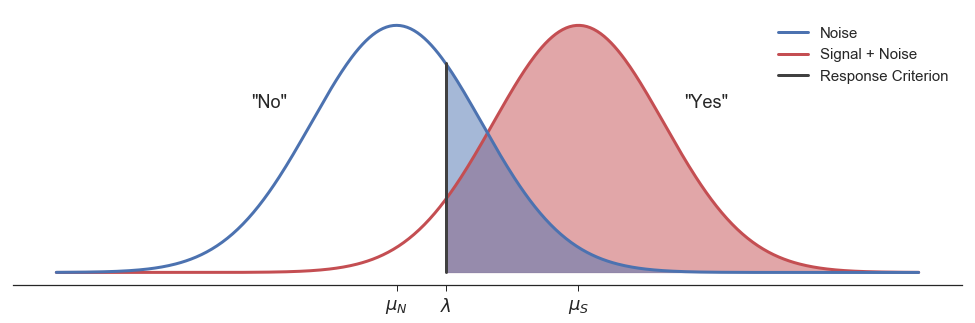

In [2]:
mu_N, mu_S, lam = 0, 2.14, 0.58
sdt.plot_simple_model(mu=[mu_N, mu_S], lam=lam)

This model predicts $h$ and $f$ as the areas under the signal and noise distributions above the response criterion (i.e., the integrals from $\lambda$ to infinity under each probability density function):

$\begin{align*}
h = \Pr(\text{"Yes"} | \text{S}) &= \int_\lambda^\infty f_S(x) dx = 1-\Phi\left( \frac{\lambda-\mu_N}{\sigma_N} \right)\\
f = \Pr(\text{"Yes"} | \text{N}) &= \int_\lambda^\infty f_N(x) dx = 1-\Phi\left( \frac{\lambda-\mu_S}{\sigma_S} \right)
\end{align*}$

These integrals are indicated by the shaded regions in the figure above, red for $h$, blue for $f$. Note that $\Phi(x)$ is the [standard normal](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) at $x$.

We can get estimates of this particular model's $h$ and $f$ predictions by using `norm.sf()`:

In [3]:
h = norm.sf(lam, loc=mu_S, scale=1)
np.round(h,2)

0.94

In [4]:
f = norm.sf(lam, loc=mu_N, scale=1)
np.round(f,2)

0.28

In its most general form, this model has five parameters: the response criterion $\lambda$ and the means and variances for each distribution $\mu_N$, $\sigma_N$, $\mu_S$, $\sigma_S$. However, not all five parameters are identifiable.

One important reason that the model is not identifiable is that it is translation, scale, and reflection invariant. This means that if we shift, scale, or horizontally flip the whole model - both distributions and the criterion (along with the associated response labels) - it predicts the same response probabilities. The location, scale, and orientation of the model with respect to the x-axis are all arbitrary.

There are a number of ways that we can fix the location and scale of the model. It is traditional to do so by setting $\mu_N = 0$ and $\sigma_N = 1$. It is also standard practice to deal with reflection invariance by arbitrarily assigning the "signal" response to the region to the right of the criterion.

Even after fixing the location, scale, and orientation, though, we have three free parameters: $\mu_S$, $\sigma_S$, and $\lambda$. For a single table of the type given above, this model is still not identifiable. This is because these three parameters can trade off one another to produce exactly the same prediction for $h$. In order to deal with this, it is traditional to set $\sigma_S = 1$ and use the data to estimate $\mu_S$ and $\lambda$.

### A brief mathemtical aside about the non-identifiability of $\mu_S$, $\sigma_S$, and $\lambda$

First, note that by setting $\mu_N = 0$ and $\sigma_N = 1$, the response criterion $\lambda$ determines the predicted response probabilities for noise-only trials. That is, $\Pr(\text{"No"}|\text{N}) = \Phi\left( \lambda \right)$ and $\Pr(\text{"Yes"}|\text{N}) = 1-\Phi\left( \lambda \right)$.

Because the signal distribution has mean $\mu_S$ and SD $\sigma_S$, $\Pr(\text{"No"}|\text{S}) = \Phi\left( \displaystyle{\frac{\lambda-\mu_S}{\sigma_S}} \right)$, and $\Pr(\text{"Yes"}|\text{S}) = 1-\Phi\left( \displaystyle{\frac{\lambda-\mu_S}{\sigma_S}} \right)$.

Two useful facts: If we [transform a normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Operations_on_normal_deviates) $X$ with mean $\mu$ and variance $\sigma^2$ by multiplying it by $\alpha$ and adding $\delta$, then the expected value is $\alpha\mu + \delta$ and the variance is $\alpha^2\sigma^2$.

Using these facts, if we transform our signal-trial random variable by multiplying it by $\displaystyle{\frac{1}{\sigma}}$ and adding $\lambda - \displaystyle{\frac{\lambda}{\sigma}}$, the mean and variance of the transformed signal-trial random variable are $\displaystyle{\frac{\mu_S}{\sigma} + \lambda - \frac{\lambda}{\sigma} = \lambda - \frac{\lambda-\mu_S}{\sigma}}$ and $\displaystyle{\frac{\sigma^2}{\sigma^2}} = 1$, respectively.

Substituting these into the formula for $\Pr(\text{"No"}|\text{S})$ above, we get $\Phi\left( \displaystyle{\frac{\lambda-\left(\lambda-\frac{\lambda-\mu_S}{\sigma_S}\right)}{\frac{\sigma_S}{\sigma_S}}} \right) = \Phi\left( \displaystyle{\frac{\lambda-\mu_S}{\sigma_S}} \right)$, which is right where we started.

All of which is to say that for any mean $\mu_S$ and variance $\sigma_S \neq 1$ in a signal-trial distribution, there is a scaled and shifted mean and an associated unit variance that predict exactly the same response probabilities. The transformation is invertible, too, so we can map back-and-forth as desired.

## Sensitivity and response bias

I wrote above that SDT is useful because it allows you to tease apart sensitivity (to a noisy signal) and response bias. As a first step toward illustrating the value of teasing sensitivity and response apart, here are three simple SDT models with $\mu_S$ (i.e., sensitivity) held constant and with different values of $\lambda$ (i.e., letting response bias vary):

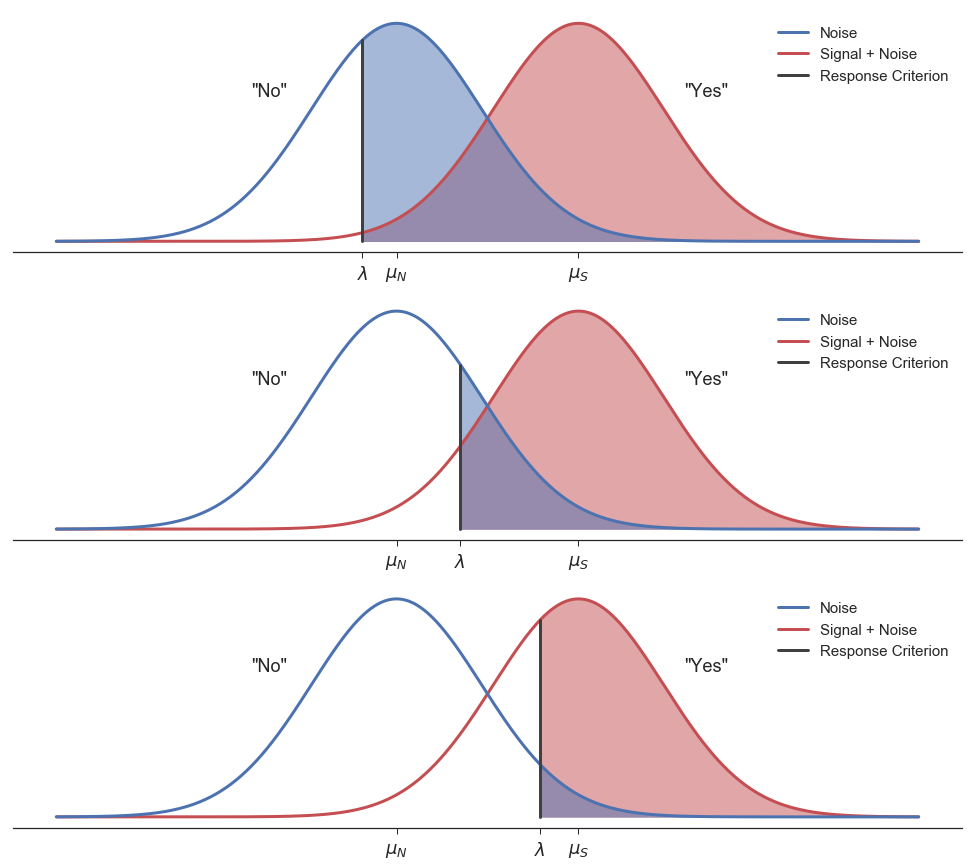

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(17,15))
lam_list = [-.4, .75, 1.69]
for lamv, ax in zip(lam_list, axes):
    sdt.plot_simple_model(mu=[mu_N, mu_S], lam=lamv, ax=ax)

By fiat, we've held the sensitivity constant in these three models, but because of differences in response bias, they produce very different predicted values of $h$ and $f$:

In [6]:
for lamv in lam_list:
    print('lambda = ' + str(np.round(lamv,2)),\
          ', h = ' + str(np.round(norm.sf(lamv, loc=mu_S),2)),\
          ', f = ' + str(np.round(norm.sf(lamv, loc=mu_N),2)))

lambda = -0.4 , h = 0.99 , f = 0.66
lambda = 0.75 , h = 0.92 , f = 0.23
lambda = 1.69 , h = 0.67 , f = 0.05


The most "liberal" criterion (-0.4) predicts nearly perfect performance on signal trials, but at the cost of a nearly 2/3 false alarm rate.

The moderate criterion (0.75) predicts only slightly worse performance on signal trials, but a much lower false alarm rate.

The most "conservative" criterion (1.69) reduces the hit rate to about 2/3 and the false alarm rate to 0.05.

Here are three models with $\lambda$ set to produce unbiased responses (more on this later), with three different values of $\mu_S$:

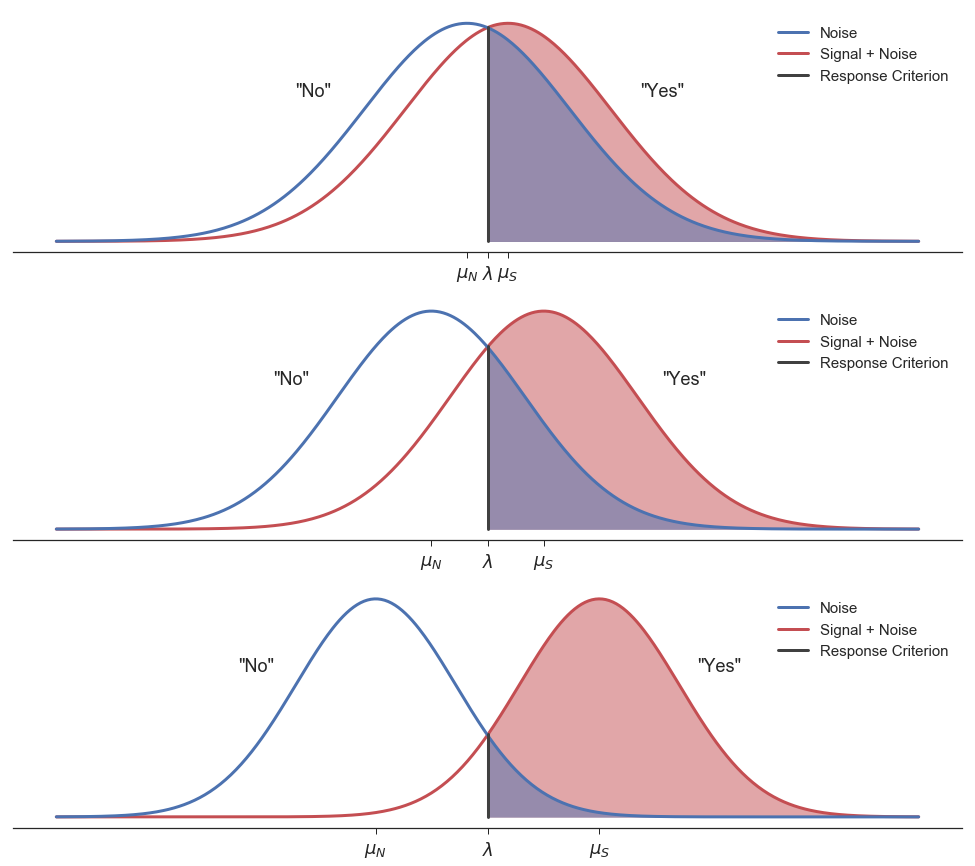

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(17,15))
mus_list = [.4, 1.2, 2.8]
lam_list = [m/2 for m in mus_list]
for mu, lamv, ax in zip(mus_list,lam_list, axes):
    sdt.plot_simple_model(mu=[mu_N, mu], lam=lamv, ax=ax)

And here are the predicted values of $h$ and $f$ for these three models:

In [8]:
for mu, lamv in zip(mus_list,lam_list):
    print('mu = ' + str(np.round(mu,2)),\
          ', lambda = ' + str(np.round(lamv,2)),\
          ', h = ' + str(np.round(norm.sf(lamv, loc=mu),2)),\
          ', f = ' + str(np.round(norm.sf(lamv, loc=mu_N),2)))

mu = 0.4 , lambda = 0.2 , h = 0.58 , f = 0.42
mu = 1.2 , lambda = 0.6 , h = 0.73 , f = 0.27
mu = 2.8 , lambda = 1.4 , h = 0.92 , f = 0.08


Note that the unbiased response criterion produces $h = 1-f$ in each case, with $h$ increasing and $f$ decreasing with the value of $\mu_S$.

## Estimating $d^\prime$ and $\lambda$ from data

While it can be useful to see how predicted response probabilities vary with known parameter values, we typically (never, as far as I can tell) know the true values of parameters. Indeed, I'm not sure it makes much sense to even talk about "the true values of parameters." SDT is useful because it allows us to state some assumptions (e.g., partiallly-random perception, deterministic response selection) and then use data to estimate unobservable parameter values that provide measures of sensitivity and response bias.

A typical use of SDT begins with data like the data shown in the tables above. Here are the tables from the first block, repeated for convenience:

Counts:

|       | "short" | "long" |
|-------|---------|--------|
| short | 36      |  14    |
| long  | 12      |  188   |

Proportions:

|       | "short" | "long" |
|-------|---------|--------|
| short | 0.72    |  0.28  |
| long  | 0.06    |  0.94  |

Thus far, I've been modeling response bias with the parameter $\lambda$. As noted above, with $\mu_N = 0$ and $\sigma_N=1$, $\lambda$ determines $f$. Starting with this, then rearranging terms, and then using the fact that the standard normal CDF is invertible, we can get a formula for using $f$ to estimate $\lambda$:

\begin{align*}
f &= 1-\Phi(\lambda)\\
\Phi(\lambda) &= 1-f\\
\lambda &= \Phi^{-1}(1-f)
\end{align*}

The symmetry of the normal distribution allows us to simplify this formula further, since for probability $p$, $\Phi^{-1}(1-p) = -\Phi^{-1}(p)$. Hence, $\lambda = -\Phi^{-1}(f)$, or, using simpler notation, $\lambda = -Z(f)$.

If we take the short stimulus trials as "noise" trials, we can use `norm.ppf()` and the estimate of $f$ above to estimate $\lambda$ for block one, which we will call $\hat{\lambda}_1$:

In [11]:
lam_1 = -norm.ppf(0.28)
print('lambda =',np.round(lam_1,2))

lambda = 0.58


Estimating sensitivity is a little bit trickier. Above, I referred to $\mu_S$ as the parameter measuring sensitivity. The more standard notation is $d^\prime$, in which case the model would look like this, with $\mu_N=0$:

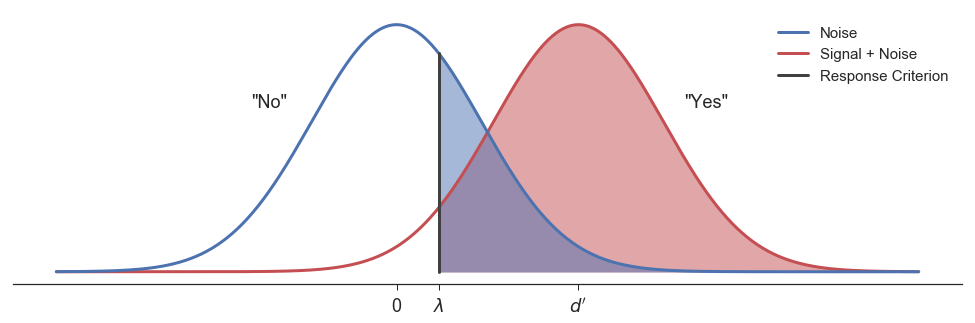

In [12]:
fd = sdt.fig_dict
fd['xtick_labs'] = ['0',r'$\lambda$',r'$d^\prime$']
sdt.plot_simple_model(mu=[mu_N, mu_S], fig_dict=fd)

Assuming $\sigma_S = 1$ and substituting $d^\prime$ for $\mu_S$, the formula for $h$ from above is $h = \displaystyle{1-\Phi\left( \lambda-d^\prime \right)}$. Rearranging terms as we did with $f$ and $\lambda$ above, and then substituting in the formula for $\lambda$, we get:

\begin{align*}
h &= 1-\Phi(\lambda-d^\prime)\\
\Phi(\lambda-d^\prime) &= 1-h\\
\lambda-d^\prime &= \Phi^{-1}(1-h)\\
\lambda-d^\prime &= -\Phi^{-1}(h)\\
d^\prime &= \Phi^{-1}(h) + \lambda\\
d^\prime &= Z(h) - Z(f)
\end{align*}

Using the estimates of $h$ and $f$ from the table above, we get:

In [15]:
dpr_1 = norm.ppf(.94) - norm.ppf(.28)
print("d' =", np.round(dpr_1,2))

d' = 2.14


Here are the tables from block two:

Counts:

|       | "short" | "long" |
|-------|---------|--------|
| short | 189     |  11    |
| long  | 16      |  34    |

Proportions:

|       | "short" | "long" |
|-------|---------|--------|
| short | 0.945   |  0.055 |
| long  | 0.32    |  0.68  |

Recall that these are data from the same listener responding to the same stimuli, presented at different rates. In block one, the long stimuli were presented 200 times and the short stimuli just 50 times, while in block two, these numbers were reversed. The listeners in this experiment were told the relative presentation rates before each block and were encouraged to guess accordingly when uncertain.

Given that the stimuli were the same in each block, it is reasonable to expect sensitivity to the duration difference ($d^\prime$) to be (close to) constant across the two blocks, and given that the listeners were told about the presentation rates and encouraged to shift their response strategies accordingly, it is reasonable to expect differences in the estimates of $\lambda$ for the two blocks.

The estimates of $d^\prime$ and $\lambda$ for the second block accord nicely with these expectations:

In [13]:
lam_2 = -norm.ppf(0.055)
print('lambda =',np.round(lam_2,2))
dpr_2 = norm.ppf(.68) - norm.ppf(.055)
print("d' =",np.round(dpr_2,2))

lambda = 1.6
d' = 2.07


Illustrating these as full SDT models, these parameter estimates give us:

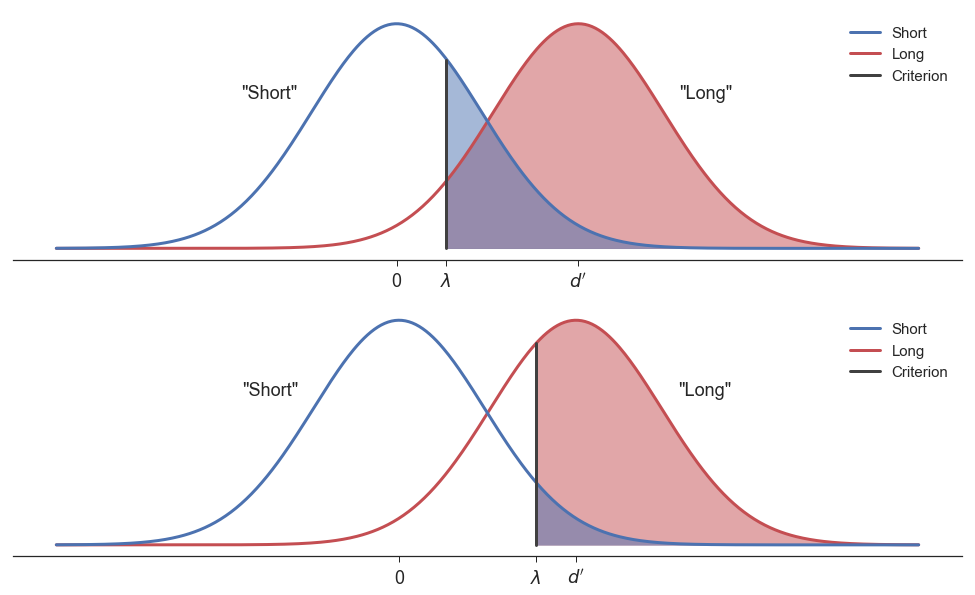

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(17,10))
fd['response_labs'] = {'N':'"Short"', 'S':'"Long"'}
fd['legend'] = ['Short','Long','Criterion']
sdt.plot_simple_model(mu=[0,dpr_1],lam=lam_1,ax=axes[0],fig_dict=fd)
sdt.plot_simple_model(mu=[0,dpr_2],lam=lam_2,ax=axes[1],fig_dict=fd)

# NOTES

- brief note about lambda vs lambda*, beta?
- brief note about ROCs?

With greater signal strength, there is less overlap between the "noise only" and "signal + noise" distributions, so the simple likelihood ratio decision rule produces higher hit rates and lower false alarm rates than the same rule with a weaker signal.

A full account of a signal detection system should take all of this into account. This weird dice game example is meant to illustrate the distinction between signal strength and decision rules, and it gives us a framework within which to introduce some useful terminology. But in typical uses of SDT, all we have is data generated by a signal detection system (i.e., hit rates, false alarm rates, etc...), and we want to draw inferences about the underlying properties of the system.

You can learn a lot about a system by looking just at hit rates and false alarm rates (or whichever values from each row of the confusion matrix are most meaningful for a given context). The beauty of SDT is that it allows you to use empirical hit and false alarm rates to estimate sensitivity (i.e., the displacement of the "signal + noise" distribution relative to the "noise only" distribution) and response bias (i.e., the criterion used to determine responses, which can be expressed in a number of different ways).

In the next notebook, I'll present more realistic situations in which we could use SDT to do this.